In [17]:
# Importing all the libraries
import torch
from torch import nn
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch
from torch import nn

torch.__version__

# Path of the file to read
train_path = '../input/chest-ctscan-images/Data/train'
test_path = '../input/chest-ctscan-images/Data/test'

print(train_path)

../input/chest-ctscan-images/Data/train


In [18]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1. Display a random image from the dataset

../input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000115 (2).png
../input/chest-ctscan-images/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000024.png
adenocarcinoma_left.lower
Random image path: ../input/chest-ctscan-images/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000024.png
Image class: adenocarcinoma_left.lower
Image height: 224
Image width: 364


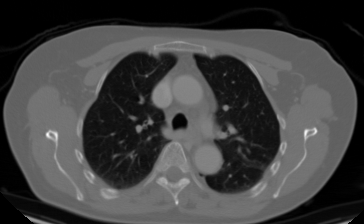

In [19]:
# Visualize an image
import random
from PIL import Image    #helps to display the image
from pathlib import Path #helps to get the file path as a path object

#''/kaggle/input/chest-ctscan-images/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib

## Display a random image of the dataset
# 1. Get all image paths (* means "any combination")
image_path = Path('../input/chest-ctscan-images/Data')
image_path_list = list(image_path.glob('*/*/*.png'))
print(image_path_list[0]) #print's first image to check if works

# 2. Get random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img
# Image.open("/content/data/pizza_steak_sushi/test/pizza/194643.jpg")

Try to check what the shape of the image is using numpy

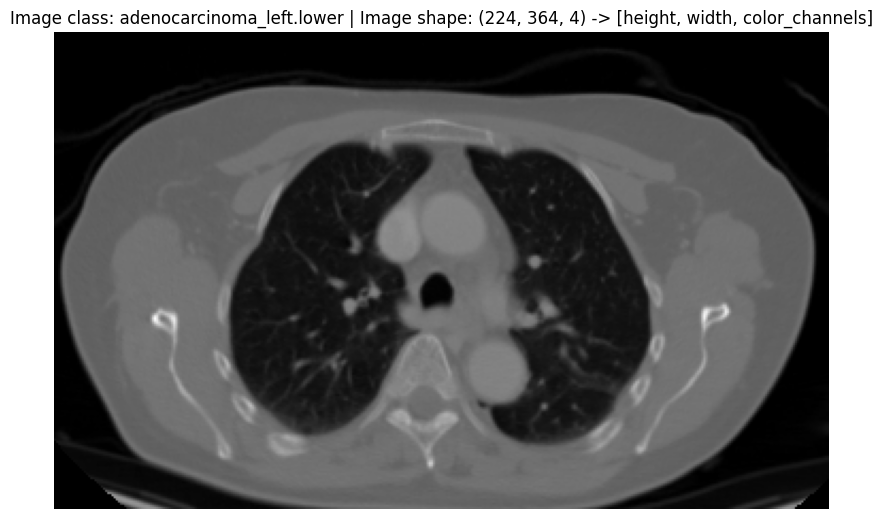

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize = (10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# 2. Applying data augmentation to the images 

In [21]:
image_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

In [22]:
image_transform(img).shape

torch.Size([4, 64, 64])

Now let's create a function to display images with and without data augmentation

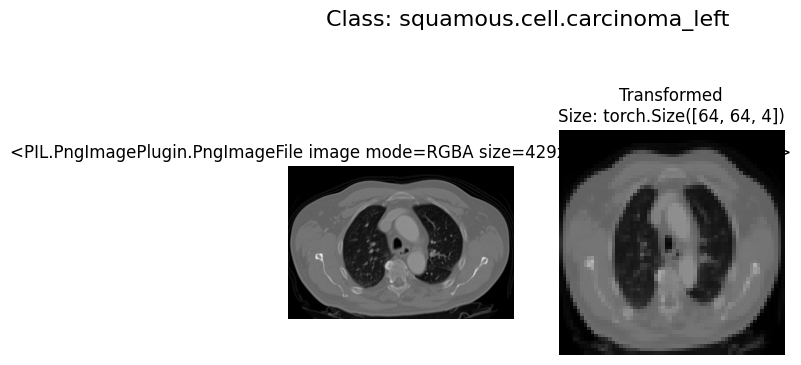

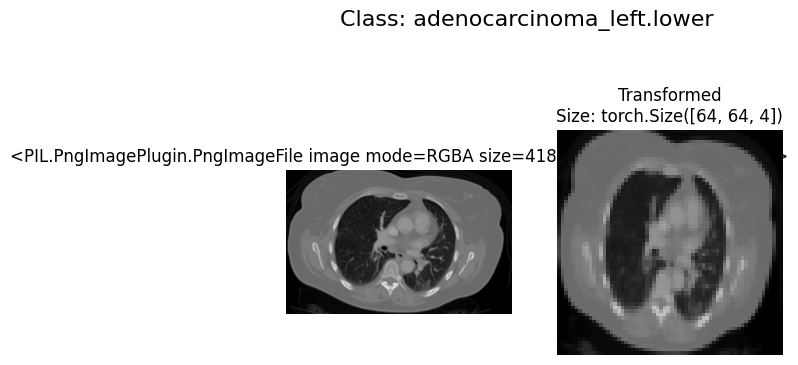

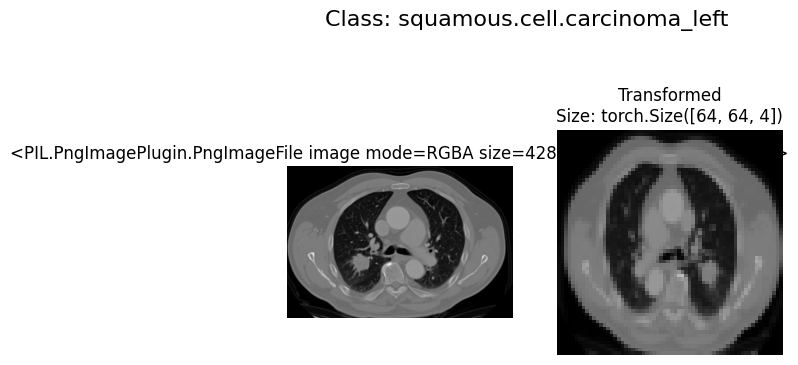

In [23]:
def plot_transformed_images(image_paths: list, transform, n = 3, seed = 42):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k = n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows = 1, ncols = 2)
            ax[0].imshow(f)
            ax[0].set_title(f)
            ax[0].axis(False)
            
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
            ax[1].axis(False)
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)
    
plot_transformed_images(image_paths = image_path_list,
                        transform = image_transform,
                        n = 3,
                        seed = None)

# 3. Using ImageFolder to load the datasets

In [24]:
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_path,
                                 transform = image_transform,
                                 target_transform = None)
test_data = datasets.ImageFolder(root = test_path,
                                transform = image_transform,
                                target_transform = None)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 613
     Root location: ../input/chest-ctscan-images/Data/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 315
     Root location: ../input/chest-ctscan-images/Data/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [25]:
#Let's display the class of one of the dataset
classes = train_data.classes
classes

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
 'normal',
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

In [26]:
# Length of the datasets are as follows
print(f"Length of train_data :{len(train_data)} | Length of test_data :{len(test_data)}")

Length of train_data :613 | Length of test_data :315


## Note: 
When using plt the order of the shape should be --> [HWC]

When using numpy the order of the shape should be --> [CHW]

# 4. Using DataLoader's to load the images in the form of batches

In [27]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                            batch_size = BATCH_SIZE,
                            num_workers = 1,
                            shuffle = True)

print(f"Training dataloader contains {len(train_dataloader)} batches of {len(train_data)} samples..")
print(f"Testing dataloader contains {len(test_dataloader)} batches of {len(test_data)} samples..")

Training dataloader contains 20 batches of 613 samples..
Testing dataloader contains 10 batches of 315 samples..


Keeping the batch size as 32 we can easily collate all of the images and process them in batches as shown above. This makes processing easier

# 5. Using a TinyVGG model to evaluate data (First Implementation)

In [34]:
# Creating the model
class TinyVGG(nn.Module):
    def __init__(self,
                input_shape:int,
                hidden_units:int,
                output_shape:int) -> None:
        super().__init__()
        
        self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                 out_channels = hidden_units,
                 kernel_size = 3,
                 stride = 1,
                 padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                 out_channels = hidden_units,
                 kernel_size = 3,
                 stride = 1,
                 padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                    stride = 2))
        
        self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                 out_channels = hidden_units,
                 kernel_size = 3,
                 stride = 1,
                 padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                 out_channels = hidden_units,
                 kernel_size = 3,
                 stride = 1,
                 padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                    stride = 2))
        
        self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 13 * 13,
                 out_features = output_shape)
        )
    def forward(self, x):
        x = self.convblock1(x)
        print(f"Shape of x: {x.shape}")
        x = self.convblock2(x)
        print(f"Shape of x: {x.shape}")
        x = self.classifier(x)
        print(f"Shape of x: {x.shape}")
        return x

In [35]:
torch.manual_seed(42)
model = TinyVGG(input_shape = 4,
               hidden_units = 10,
               output_shape = len(classes)).to(device)
model

TinyVGG(
  (convblock1): Sequential(
    (0): Conv2d(4, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=4, bias=True)
  )
)

In [36]:
# Download torchinfo to better represent data
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

In [37]:
from torchinfo import summary
BATCH_SIZE = 32
summary(model, input_size = (BATCH_SIZE, 4, 64, 64))

Shape of x: torch.Size([32, 10, 30, 30])
Shape of x: torch.Size([32, 10, 13, 13])
Shape of x: torch.Size([32, 4])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 4]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          370
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia